In [2]:
# Importing the required files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns

In [11]:
# Load the original dataset.
file_path = "E:\\Studies\\IIT\\4 - Forth Year\\Final Year Project\\QuanNetDetct\\Datasets\\Darknet.csv"
darknet_data = pd.read_csv(file_path)

# **Model Pre-processing**

In [12]:
#  Process 1 - Filter TLS-related traffic.
tls_ports = [443, 993, 995, 465, 8443]
tls_traffic = darknet_data[
    (darknet_data['Dst Port'].isin(tls_ports)) &  # Destination port is TLS-related.
    (darknet_data['Protocol'] == 6)              # Protocol is TCP.
]

print("TLS traffic filtered!")

TLS traffic filtered!


In [14]:
#  Process 2 - Encoding the TLS traffic data.

# Creating an object of the LabelEncoder class
label_encoder = LabelEncoder()

# Encode string columns
for column in tls_traffic.select_dtypes(include=['object']).columns:
    # Assign explicitly to avoid warning
    encoded_column = label_encoder.fit_transform(tls_traffic[column])
    tls_traffic.loc[:, column] = encoded_column

print("Encoding Completed!")

Encoding Completed!


In [15]:
# Process 3 - Scaling the TLS traffic data

# Step 1: Make a copy of the DataFrame to avoid SettingWithCopyWarning
tls_traffic = tls_traffic.copy()

# Step 2: Identify Numeric Columns to Scale
# Exclude columns that should not be scaled
columns_to_exclude = ['Protocol', 'Dst Port']  # Add any additional columns to exclude if needed
numeric_columns = tls_traffic.select_dtypes(include=['float64', 'int64']).columns.difference(columns_to_exclude)

# Step 3: Check and Replace Invalid Values
# Replace infinity values with NaN
tls_traffic[numeric_columns] = tls_traffic[numeric_columns].replace([np.inf, -np.inf], np.nan)

# Fill NaN values with column means
tls_traffic[numeric_columns] = tls_traffic[numeric_columns].fillna(tls_traffic[numeric_columns].mean())

# Step 4: Scale Only the Selected Numeric Columns
scaler = MinMaxScaler()
tls_traffic[numeric_columns] = scaler.fit_transform(tls_traffic[numeric_columns])

# Print confirmation
print("Scaling completed!")

Scaling completed!


# **Feature Selection and Feature Importance**

In [16]:
# Process 4 - Feature Selection.

# Define the target variable.
target_variable = 'Label'

# Calculate the correlation matrix.
correlation_matrix = tls_traffic.corr()

# Extract correlations with the target variable.
target_correlation = correlation_matrix[target_variable].drop(target_variable)

# Set a threshold for correlation (absolute value).
threshold = 0.1  # Adjust this based on your needs (e.g., 0.1 for weak correlation).

# Select features that are strongly correlated with the target.
selected_features = target_correlation[abs(target_correlation) > threshold]

# Remove identifier columns from the selected features.
identifiers = ['Flow ID', 'Src IP']
selected_features = selected_features.drop(index=identifiers, errors='ignore')

# Print the selected features and their correlation values.
print("Selected Features Based on Correlation with 'Label':")
print(selected_features)

# Update tls_traffic to retain only selected features and the target variable.
tls_traffic = tls_traffic[selected_features.index.tolist() + [target_variable]]

# Save the updated dataset for review.
tls_traffic.to_csv("4. Feature_Selected_Dataset_Without_Identifiers.csv", index=False)
print("Feature-selected dataset without identifiers saved as '4. Feature_Selected_Dataset_Without_Identifiers.csv'")

Selected Features Based on Correlation with 'Label':
Timestamp                -0.300921
Fwd Packet Length Mean    0.111124
Fwd PSH Flags             0.116855
SYN Flag Count           -0.177119
Fwd Segment Size Avg      0.111124
Subflow Fwd Packets       0.100899
FWD Init Win Bytes        0.295231
Bwd Init Win Bytes        0.269703
Fwd Seg Size Min          0.754610
Name: Label, dtype: float64
Feature-selected dataset without identifiers saved as '4. Feature_Selected_Dataset_Without_Identifiers.csv'


Feature Importance:
                  Feature  Importance
0               Timestamp    0.353997
8        Fwd Seg Size Min    0.236636
6      FWD Init Win Bytes    0.189628
7      Bwd Init Win Bytes    0.160596
1  Fwd Packet Length Mean    0.021654
4    Fwd Segment Size Avg    0.021053
3          SYN Flag Count    0.008305
2           Fwd PSH Flags    0.005236
5     Subflow Fwd Packets    0.002895


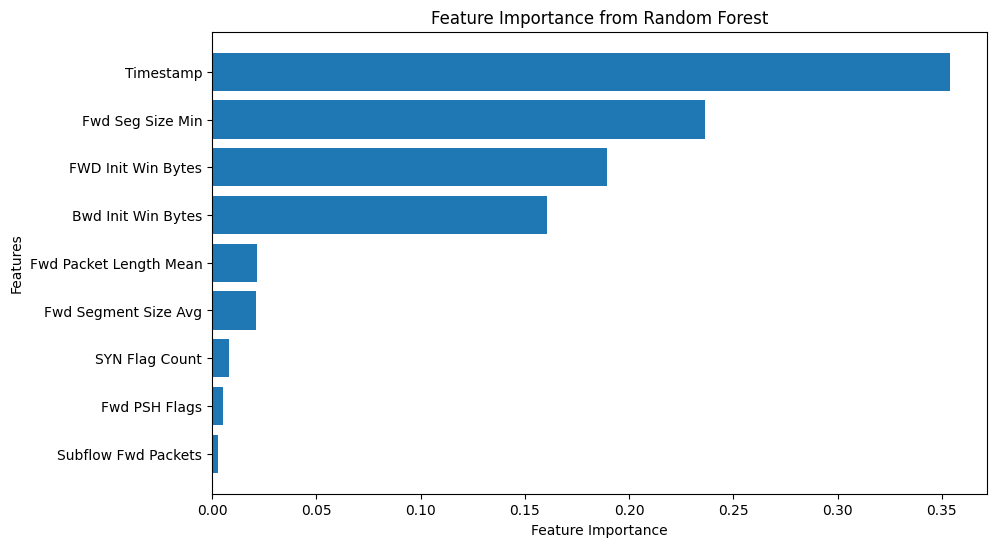

In [46]:
# Process 5 - Feature Importance validation.

# Ensure the target variable is properly encoded
tls_traffic['Label'] = tls_traffic['Label'].astype(int)  # Convert to integer if needed

# Separate features and target variable.
X = tls_traffic.drop(columns=['Label'])
y = tls_traffic['Label']

# Initialize and train the Random Forest model.
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X, y)

# Calculate feature importance.
feature_importances = rf_model.feature_importances_

# Create a DataFrame for better visualisation.
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Print feature importance.
print("Feature Importance:")
print(feature_importance_df)

# Plot feature importance.
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.show()

# **Spliting Training and Testing Dataset**

In [47]:
# Process 6 - Splitting the dataset.
X = tls_traffic.drop(columns=['Label'])
y = tls_traffic['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Training and testing datasets created.")

Training and testing datasets created.


# **Quantum Circuit Intializatoin and Execution**

In [50]:
# Define the number of qubits based on the number of features
num_qubits = X_train.shape[1]

# Create a quantum device with the required number of qubits
dev = qml.device("default.qubit", wires=num_qubits)

# Define the quantum circuit with the QNode decorator
@qml.qnode(dev, interface="tf")  # Specify TensorFlow as the interface
def quantum_circuit(inputs, weights):
    # Embed classical data into the quantum circuit using AngleEmbedding
    qml.templates.AngleEmbedding(inputs, wires=range(num_qubits))
    # Apply trainable quantum layers with entanglement
    qml.templates.BasicEntanglerLayers(weights, wires=range(num_qubits))
    # Return the expectation value of PauliZ on the first qubit
    return qml.expval(qml.PauliZ(0))

# Print the number of qubits (wires) in the quantum device
print("Number of qubits (wires) been used:", len(dev.wires))

# Test the quantum circuit
inputs = tf.random.uniform((num_qubits,))
weights = tf.random.uniform((2, num_qubits))  # Shape matches num_layers and num_qubits
result = quantum_circuit(inputs, weights)
print("Quantum circuit output:", result)

# Print confirmation
print("Quantum device and circuit defined successfully!")

Number of qubits (wires) been used: 9
Quantum circuit output: tf.Tensor(0.035193758513919426, shape=(), dtype=float64)
Quantum device and circuit defined successfully!


# **Hybrid Quantum-Classical Neural Network**

In [26]:
# Define the weight shape for the quantum circuit
num_layers = 2  # Number of layers in the quantum circuit
weight_shape = {"weights": (num_layers, num_qubits)}

# Create a custom Keras layer that integrates the quantum circuit
class QuantumLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(QuantumLayer, self).__init__()
        # Initialize trainable weights for the quantum circuit
        self.q_weights = self.add_weight(
            name="q_weights",
            shape=weight_shape["weights"],
            initializer="random_normal",
            trainable=True,
        )

    def call(self, inputs):
        # Function to execute the quantum circuit
        @tf.autograph.experimental.do_not_convert  # Suppress AutoGraph warnings here
        def circuit_execution(input_sample):
            # Call the quantum circuit
            result = quantum_circuit(input_sample, self.q_weights)
            # Ensure the output is converted to the correct dtype
            result = tf.cast(result, dtype=tf.float32)
            return result

        # Apply the quantum circuit to each input sample in the batch
        outputs = tf.map_fn(
            circuit_execution, inputs, fn_output_signature=tf.float32
        )
        # Ensure the output is 2D (batch_size, features)
        outputs = tf.expand_dims(outputs, axis=-1)  # Add an extra dimension
        return outputs

    def compute_output_shape(self, input_shape):
        # The output shape is (batch_size, 1)
        return (input_shape[0], 1)

# Define the hybrid Quantum-Classical model
def create_hybrid_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(num_qubits,)),  # Input layer matching the number of features
        QuantumLayer(),                      # Quantum layer for feature extraction
        tf.keras.layers.Flatten(),           # Flatten the output of the quantum layer
        tf.keras.layers.Dense(1, activation="sigmoid"),  # Dense layer for binary classification
    ])
    return model

# Create the model
hybrid_model = create_hybrid_model()

# Print the model summary
hybrid_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantum_layer_1 (QuantumLay  (None, 1)                18        
 er)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


# **Compiling the model**

In [27]:
# Compile the model
hybrid_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Adam optimizer with learning rate
    loss="binary_crossentropy",  # Binary cross-entropy loss for binary classification
    metrics=[
        "accuracy", 
        tf.keras.metrics.Precision(),  # Track precision
        tf.keras.metrics.Recall(),  # Track recall
    ]
)

print("Model compiled successfully!")

Model compiled successfully!


# **Quantum Neural Network Model Training**

In [28]:
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model.keras",  # Use the .keras extension for the filepath
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, verbose=1
)

# Train the model
history = hybrid_model.fit(
    X_train,
    y_train,
    epochs=20,  # Number of training epochs
    batch_size=32,  # Batch size
    validation_split=0.2,  # Use 20% of the training data for validation
    verbose=1,  # Display training progress
    callbacks=[early_stopping, checkpoint, lr_scheduler]  # Add callbacks
)

print("Model training complete!")

Epoch 1/20
345/346 [============================>.] - ETA: 0s - loss: 0.6663 - accuracy: 0.1450 - precision_1: 0.3383 - recall_1: 1.0000
Epoch 1: val_loss improved from inf to 0.63647, saving model to best_model.keras
346/346 [==============================] - 15s 32ms/step - loss: 0.6661 - accuracy: 0.1450 - precision_1: 0.3384 - recall_1: 1.0000 - val_loss: 0.6365 - val_accuracy: 0.1597 - val_precision_1: 0.3454 - val_recall_1: 1.0000 - lr: 0.0010
Epoch 2/20
345/346 [============================>.] - ETA: 0s - loss: 0.6151 - accuracy: 0.1450 - precision_1: 0.3385 - recall_1: 1.0000
Epoch 2: val_loss improved from 0.63647 to 0.58662, saving model to best_model.keras
346/346 [==============================] - 11s 31ms/step - loss: 0.6153 - accuracy: 0.1450 - precision_1: 0.3384 - recall_1: 1.0000 - val_loss: 0.5866 - val_accuracy: 0.1597 - val_precision_1: 0.3454 - val_recall_1: 1.0000 - lr: 0.0010
Epoch 3/20
345/346 [============================>.] - ETA: 0s - loss: 0.5650 - accuracy:

# **Evaluating the Model** 

In [31]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_precision, test_recall = hybrid_model.evaluate(X_test, y_test, verbose=1)

# Print evaluation results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")

108/108 [==============================] - 1s 11ms/step - loss: -0.2677 - accuracy: 0.1480 - precision_1: 0.3400 - recall_1: 1.0000
Test Loss: -0.2677113711833954
Test Accuracy: 0.1479872614145279
Test Precision: 0.3399942219257355
Test Recall: 1.0


# **Saving the model**

In [32]:
# Save the trained model
hybrid_model.save("hybrid_quantum_model.keras")
print("Model saved successfully!")

Model saved successfully!


# **Generating Predictions**

In [36]:
# Generate predictions
y_pred_prob = hybrid_model.predict(X_test)  # Predicted probabilities
y_pred = (y_pred_prob > 0.5).astype(int)    # Convert probabilities to binary predictions

# Ensure y_test is a NumPy array
y_test_array = y_test.values if isinstance(y_test, pd.Series) else y_test

# Print some predictions
print("Predicted Labels:", y_pred[:10].flatten())
print("True Labels:", y_test_array[:10].flatten())

108/108 [==============================] - 1s 10ms/step
Predicted Labels: [1 1 1 1 1 1 1 1 1 1]
True Labels: [3 0 0 3 0 0 0 0 2 0]


# **Confusion Matrix**

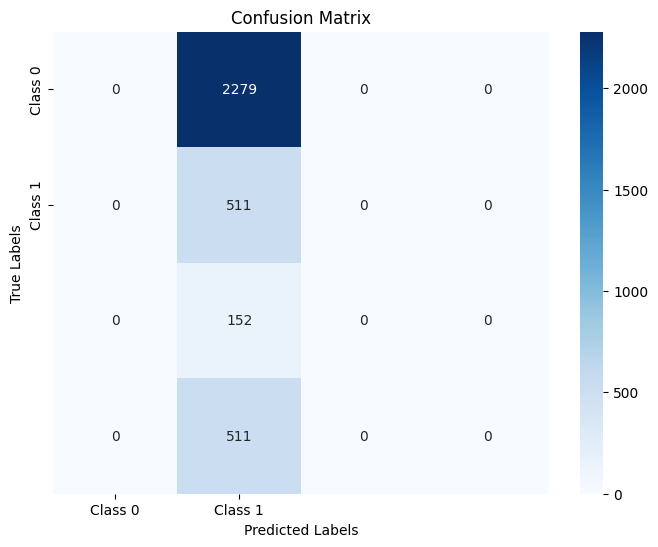

In [38]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test_array, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# **Classification Report generating**

In [52]:
# Automatically infer target names
target_names = [f"Class {i}" for i in np.unique(y_test_array)]

# Generate the classification report with zero_division parameter set
report = classification_report(y_test_array, y_pred, target_names=target_names, zero_division=0)
print("\nClassification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00      2279
     Class 1       0.15      1.00      0.26       511
     Class 2       0.00      0.00      0.00       152
     Class 3       0.00      0.00      0.00       511

    accuracy                           0.15      3453
   macro avg       0.04      0.25      0.06      3453
weighted avg       0.02      0.15      0.04      3453



# **Training History Plot**

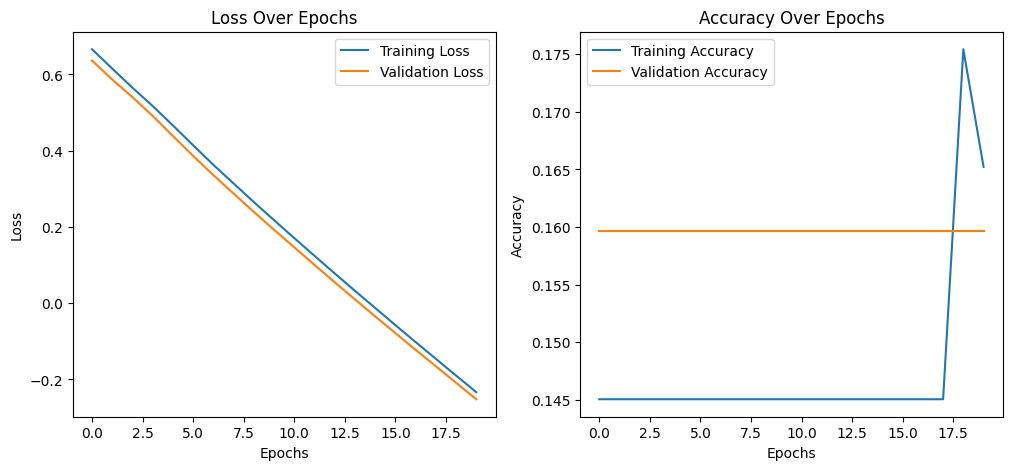

In [43]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()